In [81]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.environ.get("OPEN_API_KEY")

In [82]:
from langchain_openai import ChatOpenAI
#llm creation
llm = ChatOpenAI(model_name="gpt-3.5-turbo")

#llm.invoke("who is the king in then north?")

In [ ]:
from langchain_core.tools import tool

@tool
def get_stock_price(stok: str)->str:
    ''' Return the current stock price of the given stock
    param stock: stock name
    return current price of the stock
    '''
    return {
        "HCL": 1280,
        "TCS": 3000,
        "IDFC": 200
    }.get(stok, 0)
    
    
tool_list = [get_stock_price]

#bind with llm tools
llm_with_tools = llm.bind_tools(tool_list)

#llm_with_tools.invoke("what is the price of HCL stock")

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

#state of the graph
class State(TypedDict):
	messages: Annotated[list, add_messages]

def chatbot(state: State) -> State:
    # Preserve message history by appending the new response to the existing messages
    print(f"Before LLM {state}")
    response = { "messages" : [llm_with_tools.invoke(state["messages"])]}
    print(f"after LLM {response}")
    return response

#graph configuation

builder = StateGraph(State)
builder.add_node("chat_node", chatbot)
builder.add_node("tools", ToolNode(tool_list))
builder.add_edge(START, "chat_node")
builder.add_conditional_edges('chat_node', tools_condition)
builder.add_edge("tools", "chat_node")
graph = builder.compile()

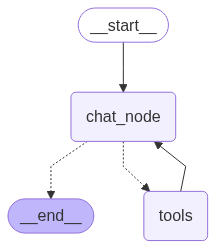

In [85]:
from IPython.display import Image, display

#display the created graph as an image
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain.schema import HumanMessage
from pprint import pprint
chat_history = []
# there is a alternative with MemorySaver
while True:
    input_msg = input("You: ")
    if input_msg in {"quit", "exit"}:
        break
    chat_history.append(HumanMessage(content=input_msg))
    response = graph.invoke({
        "messages": chat_history
    })
    chat_history = response["messages"]
    pprint(chat_history)

Before LLM {'messages': [HumanMessage(content='what is the price of 10 HCL stocks?', additional_kwargs={}, response_metadata={}, id='a9117424-6036-42e7-8e1a-e34342b29b6a')]}
after LLM {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sWFszE9y30Ed1xCKvP0AXLMp', 'function': {'arguments': '{"stok": "HCL"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_SLB0FOyiRihuek1ZGG1CmUK2', 'function': {'arguments': '{"stok": "HCL"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_CzcLOeofUrqzFOaTb10NtOjM', 'function': {'arguments': '{"stok": "HCL"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_BuTpc1czR6ZtDgIoC5GCaTQR', 'function': {'arguments': '{"stok": "HCL"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_nSXXltT8wPDV3hFTiQZ7Dbbh', 'function': {'arguments': '{"stok": "HCL"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_Y6QqDbqeq27iqTbe8Jj8zbXn', 'function': {'arguments': '{"stok": 